In [ ]:
# figpath = '/home/jovyan/projects/P46_Adult-heart_Visium/notebooks/Revision/figures'

# Import required modules

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import celltypist
from celltypist import models

import scipy

import scanpy.external as sce

In [2]:
import session_info
session_info.show()

In [3]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [4]:
sc.settings.verbosity = 1          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120)

# Prepare functions

# Read in anndata

In [8]:
adata_vis = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium_foetal_healthy-all_raw.h5ad')

# subset OCT data
adata_vis = adata_vis[adata_vis.obs['modality']=='Visium']

# log-normalise
sc.pp.filter_genes(adata_vis, min_cells=3)
sc.pp.normalize_total(adata_vis, target_sum=1e4)
sc.pp.log1p(adata_vis)

adata_vis

AnnData object with n_obs × n_vars = 19590 × 22806
    obs: 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group', 'JC_edit', 'sample_for_cell2loc', 'week', 'leiden', 'region_cluster', 'AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight', 'VentricularCardiomyocytesLeftCompact', 'VentricularCardiomyocytesRightCompact', 'VentricularCardiomyocytesLeftTrabeculated', 'VentricularCardiomyocytesRightTrabeculated', 'SinoatrialNodeCardiomyocytes', 'AtrioventricularNodeCardiomyocytes', 'VentricularConductionSystemProximal', 'VentricularConductionSystemDistal', 'GreatVesselAdventitialFibroblasts'

In [9]:
adata_vis.var_names_make_unique()

In [10]:
# modify annotations for matching with factor analysis
annotation_edit_dict = {
   'AV valves':'Valves',
    'Aortic valve':'Valves',
    'Valve apparatus':'Valves',
    'Atrium - Left':'Atrium',
     'Atrium - Right':'Atrium',
    'Ventricle - Compact - Left':'Ventricle - Compact',
    'Ventricle - Compact - Right':'Ventricle - Compact',
    'Ventricle - Trabeculated - Left':'Ventricle - Trabeculated',
    'Ventricle - Trabeculated - Right':'Ventricle - Trabeculated',
}
adata_vis.obs['annotation_final_mod']=adata_vis.obs['annotation_final'].astype('str').copy()
adata_vis.obs.replace({'annotation_final_mod':annotation_edit_dict}, 
                      inplace=True)
adata_vis.obs['annotation_final_mod'] = adata_vis.obs['annotation_final_mod'].astype('category')

#reorder annotations
annotations_order = [
   'Atrium',
        'Ventricle - Compact',
     'Ventricle - Trabeculated',
        'SAnode',
        'AVnode',
    'VCS - Proximal',
        'VCS - Distal',
        'Great vessel',
        'Coronary vessel',
    'Ductus arteriosus',
        'Adventitia - Coronary',
     'Adventitia - GV',
    'Epicardium',
        'Endocardium - Atrial', 
    'Endocardium - Ventricular',
        'Endocardial cusion',
        'AV ring',
    'Valves',
  #   'LN',
            ]
adata_vis.obs['annotation_final_mod'].cat.reorder_categories(annotations_order, inplace=True)

In [11]:
# check spot
adata_vis.obs['annotation_final_mod'].value_counts()

Ventricle - Compact          6294
Great vessel                 2871
Ventricle - Trabeculated     2437
Atrium                       1869
Endocardium - Ventricular    1800
Epicardium                   1092
Adventitia - GV               879
VCS - Distal                  670
Adventitia - Coronary         411
Endocardium - Atrial          318
VCS - Proximal                245
Valves                        237
AV ring                       196
Ductus arteriosus              71
Endocardial cusion             64
AVnode                         58
Coronary vessel                51
SAnode                         27
Name: annotation_final_mod, dtype: int64

# Read in index spots

In [12]:
# read in saved indices
indices = utils.read_pkl('/nfs/team205/heart/anndata_objects/Foetal/celltypist/tissuetypist/milo_index_spots.pkl')

# concatenate dictionary
indices_conc = []
for cells in indices.values():
    indices_conc = indices_conc + cells
if len(indices_conc) == len(set(indices_conc)):
    print(f'total spot number: {len(indices_conc)}')
else:
    print('ERROR: spot indices are duplicated')

total spot number: 1186


In [14]:
# check spot number of each structure
adata_vis[indices_conc].obs['annotation_final_mod'].value_counts()

Ventricle - Compact          95
Great vessel                 93
Atrium                       92
Endocardium - Ventricular    90
Epicardium                   82
Ventricle - Trabeculated     81
Adventitia - GV              75
Ductus arteriosus            71
VCS - Distal                 69
Endocardial cusion           64
Adventitia - Coronary        62
AVnode                       58
Endocardium - Atrial         57
Coronary vessel              51
Valves                       48
VCS - Proximal               38
AV ring                      33
SAnode                       27
Name: annotation_final_mod, dtype: int64

# Splitting indices for cross validation

* split into 5 groups

In [15]:
splitted_indices = {}
for i,spots in enumerate(indices.values()):
    for j,arr in enumerate(np.array_split(spots, 5)):
        if i==0:
            splitted_indices[f'fold{str(j+1)}'] = list(arr)
        else:
            splitted_indices[f'fold{str(j+1)}'] = splitted_indices[f'fold{str(j+1)}']+list(arr)

In [16]:
# check
for i,key in enumerate(splitted_indices.keys()):
    values = splitted_indices[key]
    if i==0:
        splitted_df = pd.DataFrame({'fold':np.repeat(key,len(values)),
                                    'indices':values})
    else:
        df = pd.DataFrame({'fold':np.repeat(key,len(values)),
                                    'indices':values})
        splitted_df = pd.concat([splitted_df,df])
splitted_df.set_index('indices',inplace=True)

# add annotations
splitted_df['annotation_final_mod'] = adata_vis.obs['annotation_final_mod'].reindex(splitted_df.index)

# crosstab
pd.crosstab(splitted_df['annotation_final_mod'],splitted_df['fold'])

fold,fold1,fold2,fold3,fold4,fold5
annotation_final_mod,,,,,
Atrium,19,19,18,18,18
Ventricle - Compact,19,19,19,19,19
Ventricle - Trabeculated,17,16,16,16,16
SAnode,6,6,5,5,5
AVnode,12,12,12,11,11
VCS - Proximal,8,8,8,7,7
VCS - Distal,14,14,14,14,13
Great vessel,19,19,19,18,18
Coronary vessel,11,10,10,10,10


In [17]:
# save splitted indices
utils.save_pkl(splitted_indices, file='/nfs/team205/heart/anndata_objects/Foetal/celltypist/tissuetypist/milo_index_spots_splitted.pkl')

# Training CellTypist model for cross-validation

In [18]:
groupby = 'annotation_final_mod'

In [19]:
%%time
# train with all genes
for fold in splitted_indices.keys():
    print(f'##### CellTypist training with removing {fold} #####')
    indices_conc_train = list(set(indices_conc)-set(splitted_indices[fold]))
    print(adata_vis[indices_conc_train].shape)
    model = celltypist.train(adata_vis[indices_conc_train], # all genes
                             labels = groupby,
                             n_jobs = 10,
                             feature_selection = False, # since manually selected
                             check_expression = False
                            )
    # Save the model
    model.write(f'/nfs/team205/heart/anndata_objects/Foetal/celltypist/tissuetypist/traindata_model_crossval_remove-{fold}.pkl')
    print('')

🍳 Preparing data before training


##### CellTypist training with removing fold1 #####
(941, 22806)


✂️ 2347 non-expressed genes are filtered out
🔬 Input data has 941 cells and 20459 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!
🍳 Preparing data before training



##### CellTypist training with removing fold2 #####
(944, 22806)


✂️ 2342 non-expressed genes are filtered out
🔬 Input data has 944 cells and 20464 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!
🍳 Preparing data before training



##### CellTypist training with removing fold3 #####
(949, 22806)


✂️ 2408 non-expressed genes are filtered out
🔬 Input data has 949 cells and 20398 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!
🍳 Preparing data before training



##### CellTypist training with removing fold4 #####
(954, 22806)


✂️ 2386 non-expressed genes are filtered out
🔬 Input data has 954 cells and 20420 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!
🍳 Preparing data before training



##### CellTypist training with removing fold5 #####
(956, 22806)


✂️ 2344 non-expressed genes are filtered out
🔬 Input data has 956 cells and 20462 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!



CPU times: user 3.47 s, sys: 1.16 s, total: 4.63 s
Wall time: 2min 22s


# Predict test data: each fold

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [6]:
# read in splitted indices
splitted_indices = utils.read_pkl('/nfs/team205/heart/anndata_objects/Foetal/celltypist/tissuetypist/milo_index_spots_splitted.pkl')

In [13]:
prediction_results = {}
accuracy_scores = []
for i,fold in enumerate(splitted_indices.keys()):
    print(f'##### Testing {fold} #####')
    indices_conc_test = splitted_indices[fold]
    adata_test = adata_vis[indices_conc_test]
    prediction_results[fold] = celltypist.annotate(adata_test, 
                                      model = f'/nfs/team205/heart/anndata_objects/Foetal/celltypist/tissuetypist/traindata_model_crossval_remove-{fold}.pkl', 
                                      majority_voting = False)
    adata_test= prediction_results[fold].to_adata()
    
    # accuracy score
    y_true = adata_test.obs['annotation_final_mod']
    y_pred = adata_test.obs['predicted_labels']
    matrix = confusion_matrix(y_true, y_pred)
    # score = (matrix.diagonal()/matrix.sum(axis=1)).mean()
    score = accuracy_score(y_true, y_pred)
    accuracy_scores.append(score)

🔬 Input data has 245 cells and 22806 genes
🔗 Matching reference genes in the model


##### Testing fold1 #####


🧬 20459 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 242 cells and 22806 genes
🔗 Matching reference genes in the model


##### Testing fold2 #####


🧬 20464 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 237 cells and 22806 genes
🔗 Matching reference genes in the model


##### Testing fold3 #####


🧬 20398 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 232 cells and 22806 genes
🔗 Matching reference genes in the model


##### Testing fold4 #####


🧬 20420 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 230 cells and 22806 genes
🔗 Matching reference genes in the model


##### Testing fold5 #####


🧬 20462 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


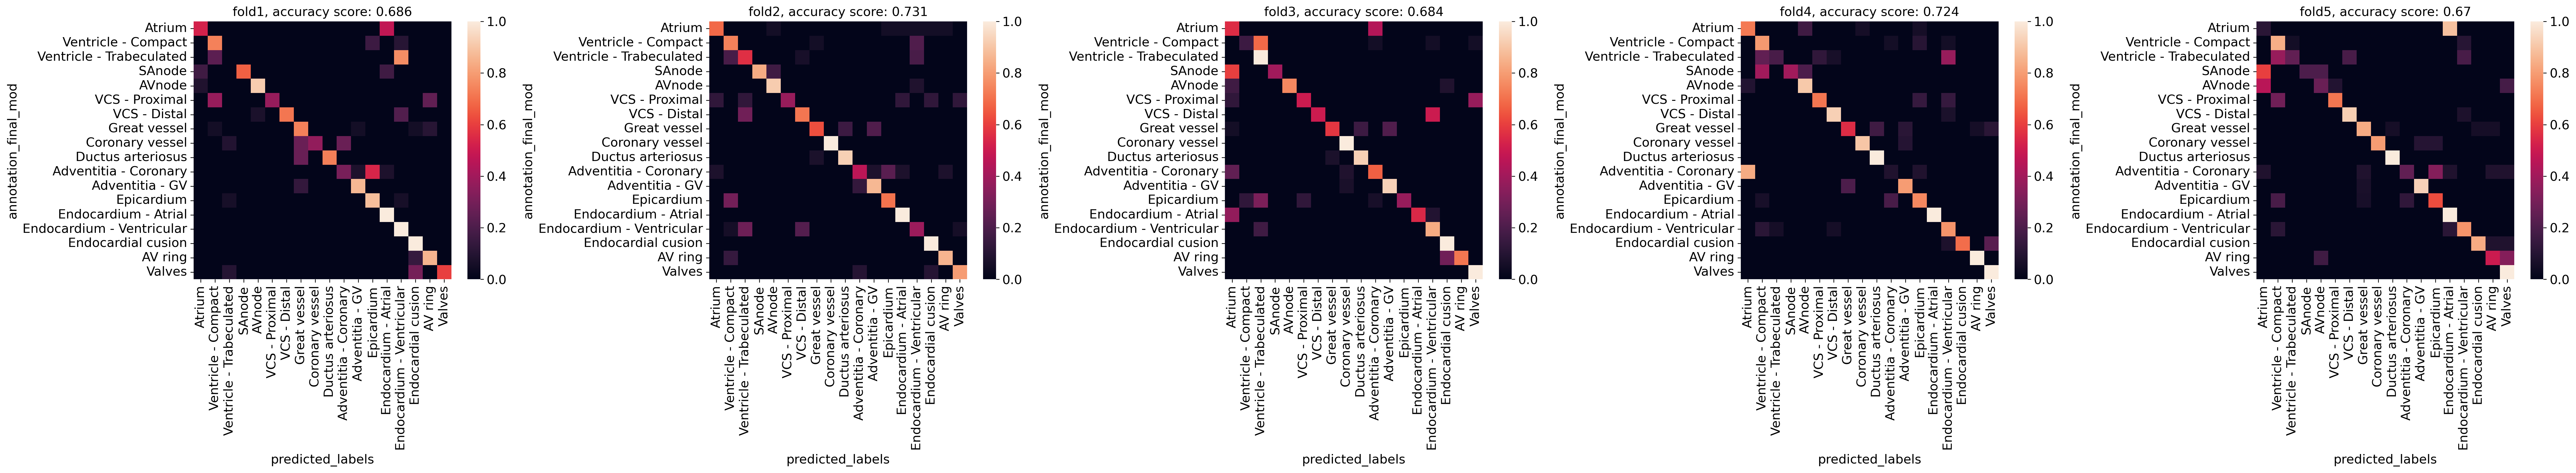

In [14]:
# plot confusion matrix
# prepare figure
nrows = 1
ncols = 5
fig,axs=plt.subplots(nrows=nrows,ncols=ncols,figsize=(40,7.5)) 
plt.rcParams['axes.grid'] = False
for i,fold in enumerate(splitted_indices.keys()):
    indices_conc_test = splitted_indices[fold]
    adata_test = adata_vis[indices_conc_test]
    adata_test= prediction_results[fold].to_adata()
    df = adata_test.obs[['annotation_final_mod','predicted_labels']]
    df = pd.crosstab(df['annotation_final_mod'],df['predicted_labels'],normalize='index')
    sns.heatmap(df.loc[annotations_order,annotations_order],ax=axs[i])
    axs[i].set_title(f'{fold}, accuracy score: {round(accuracy_scores[i],3)}')
    
fig.tight_layout()

In [15]:
# mean accuracy score
np.mean(accuracy_scores)

0.6988733393230454

# ROC curves

In [16]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

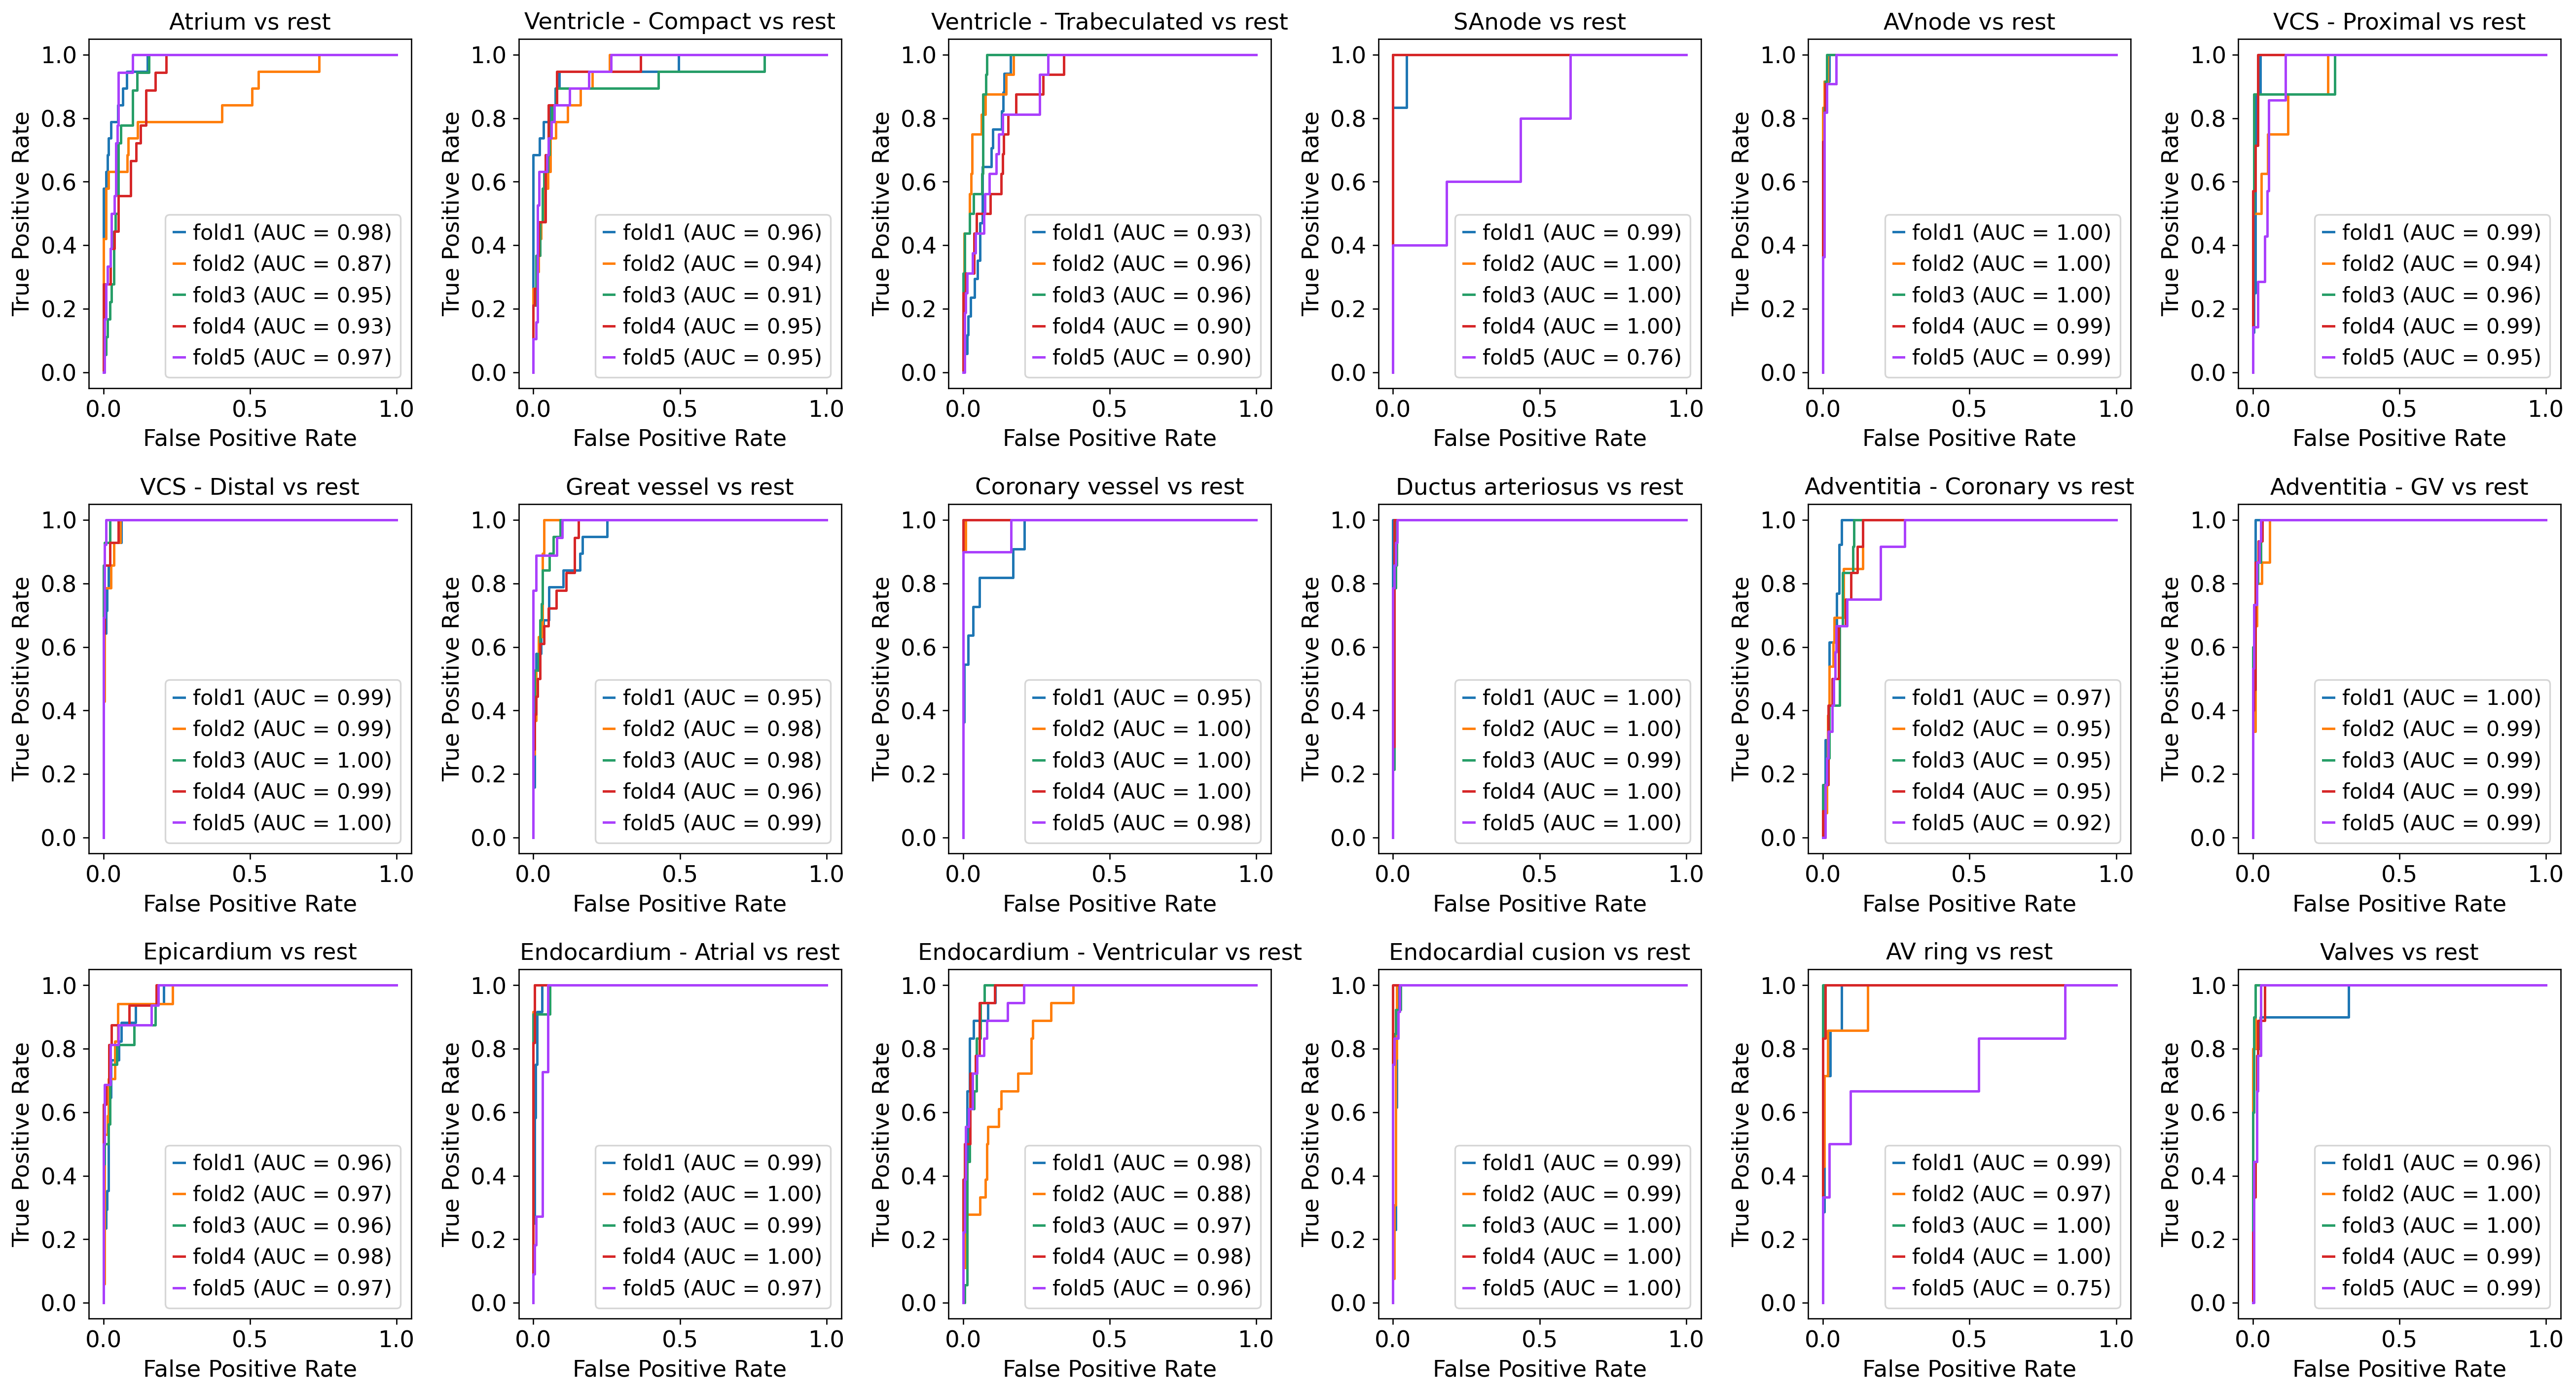

In [25]:
# prepare figure
nrows = 3
ncols = 6
fig,axs=plt.subplots(nrows=nrows,ncols=ncols,figsize=(22,12)) 

for j,fold in enumerate(splitted_indices.keys()):
    indices_conc_train = list(set(indices_conc)-set(splitted_indices[fold]))
    indices_conc_test = splitted_indices[fold]
    
    label_binarizer = LabelBinarizer().fit(adata_vis[indices_conc_test].obs['annotation_final_mod'])
    y_onehot_test = label_binarizer.transform(adata_vis[indices_conc_test].obs['annotation_final_mod'])
    # y_onehot_test.shape  # (n_samples, n_classes)
    
    y_score = prediction_results[fold].probability_matrix.copy()
    y_score = y_score.loc[adata_vis[indices_conc_test].obs_names,label_binarizer.classes_].to_numpy()
    
    # plot
    for i,class_of_interest in enumerate(annotations_order):
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=fold, # f"{class_of_interest} vs the rest",
            color=sns.color_palette()[j],
            plot_chance_level=False,
            ax=axs[i//ncols,i%ncols]
        )
        # axs[i//ncols,i%ncols].set_axis("square")
        # axs[i//ncols,i%ncols].axline((0,0), slope=1)
        axs[i//ncols,i%ncols].set_xlabel("False Positive Rate")
        axs[i//ncols,i%ncols].set_ylabel("True Positive Rate")
        axs[i//ncols,i%ncols].set_title(f"{class_of_interest} vs rest")
        axs[i//ncols,i%ncols].legend()
fig.tight_layout()